<h3> Performing the binary optimization for the optimal number of generators

In [1]:
from Genetic_Algorithm import Binary_Genetic_Algorithm
import numpy as np
import pypsa
import matplotlib.pyplot as plt
from numpy.random import randint, rand
import pandas as pd

import logging
logging.disable(logging.INFO)

In [2]:
#working floder = "dry" or "wet"

working_folder = "dry"

csv_folder_name = "Data_Folder/Eastern_grid_data/" + working_folder + "_season_data"
result_folder = "Data_Folder/Eastern_grid_data/"+ working_folder + "_results/"

fig_size = (12,6)

network = pypsa.Network()
network.import_from_csv_folder(csv_folder_name)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version None.



In [3]:
#perform load flow for differernt generation and load condition
def PowerFlow(Network_data):
    for i in range(len(Network_data.snapshots)):
        snapshot = Network_data.snapshots[i]
        Network_data.generators.p_set = Network_data.generators.p_nom*Network_data.generators_t.p_max_pu.iloc[i] #updating the geneation with max geneartiaon
        Network_data.pf(snapshot)
    return Network_data

In [4]:
solar_inst_cost = 580000
hydro_inst_cost = 2135000#irena
road_per_km_cost = 85088 #article
substation_cost_per_mva = 29364#nea
line_cost_per_km_per_mw = 2100 #article
#40 per kW per year maintainance cost hydro irena 2021

In [5]:
#add capital cost of generators
#add cost to slack export positive import negative
for i in range(len(network.generators)):
    d_sub = network.generators.sub_dist[i]
    d_road = network.generators.road_dist[i]
    typ =network.generators.carrier[i]
    if typ == "Solar":
        network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mw*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*solar_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8
    if typ == "Hydro":
        network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mw*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*hydro_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8

/tmp/ipykernel_3122/3056344100.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mva*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*hydro_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8
/tmp/ipykernel_3122/3056344100.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mva*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*solar_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8


In [6]:
#updating network with optimal number of generators
def update_network(network,x_opt):
    network_new = network.copy()
    gen_off = np.where(x_opt == 0)
    network_new.generators=network_new.generators.drop(network_new.generators.index[gen_off], axis = 0)
    network_new.generators_t.p_max_pu = network_new.generators_t.p_max_pu.drop(network_new.generators_t.p_max_pu.columns[gen_off],axis= 1)
    return network_new

In [7]:
line_s_nom = pd.read_csv('line_s_nom.csv')
network.lines.s_nom = line_s_nom.s_nom_max.values

In [8]:
snapshots = network.snapshots
start_date = snapshots[0]
end_date = snapshots[24*2]
network.snapshots = network.snapshots[(network.snapshots >= start_date) & (network.snapshots <= end_date)]

In [9]:
def Objective(x):
    u_network = update_network(network,x)
    flow_nom = u_network.lines.s_nom.values
    is_under_limit = 1
    for i in range(len(network.snapshots)):
        snapshot = u_network.snapshots[i]
        u_network.generators.p_set = u_network.generators.p_nom*u_network.generators_t.p_max_pu.loc[snapshot] #updating the geneation with max geneartiaon
        u_network.pf(snapshot)
        bus_voltage = u_network.buses_t.v_mag_pu.loc[snapshot].values
        line_flow = u_network.lines_t.p0.loc[snapshot].values
        slack_power = u_network.generators_t.p.loc[snapshot].values[0]
        if (np.abs(line_flow)>flow_nom).any() or (bus_voltage>1.1).any() or (bus_voltage<0.9).any() or slack_power>0:
            is_under_limit = 0
            break

    if is_under_limit == 0:
        return np.inf
    if is_under_limit == 1:
        return u_network.generators.capital_cost.sum()

In [10]:
n_iter = 5
n_bits = len(network.generators)
n_pop = 50
r_cross = 0.8
r_mut = 1/float(n_bits)

problem = Binary_Genetic_Algorithm(objective=Objective,n_bits=n_bits,n_iter=n_iter,n_pop= n_pop,r_cross=r_cross,r_mut=r_mut)


In [11]:
best_bits, best_eval = problem.optimize()

Generation  0
Best Cost 987101506.9253433
Generation  1
Best Cost 987101506.9253433
Generation  2
Best Cost 987101506.9253433
Generation  3
Best Cost 882922615.2000736
Generation  4
Best Cost 710835744.8274097


In [15]:
optimal_network = update_network(network,best_bits)

In [16]:
optimal_network= PowerFlow(optimal_network)

<AxesSubplot:xlabel='snapshot'>

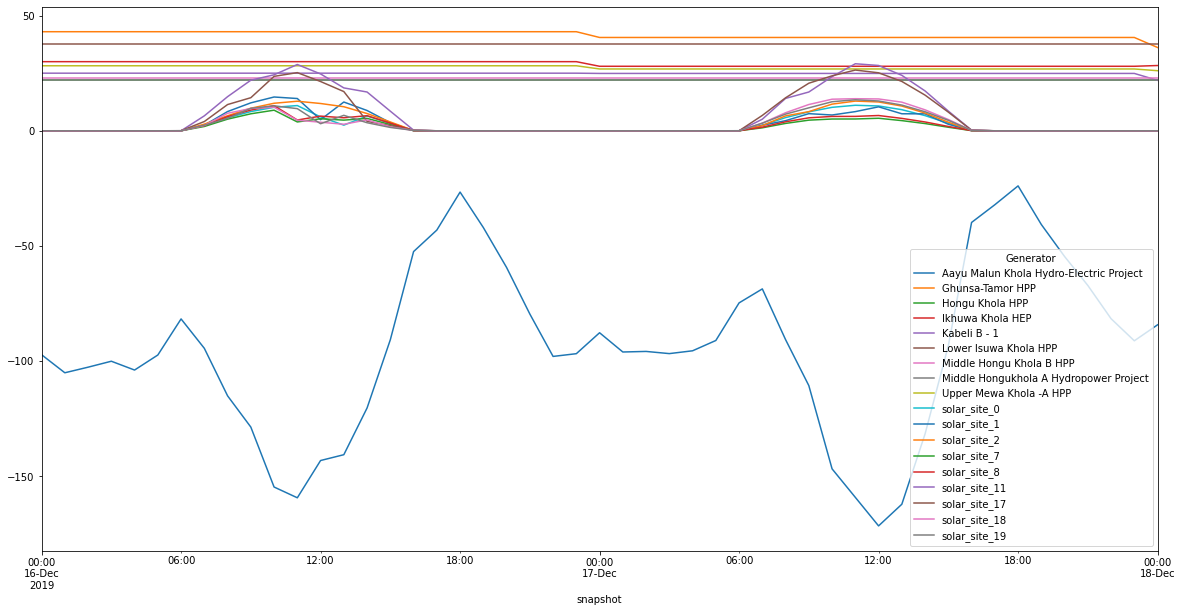

In [17]:
fig,ax = plt.subplots(figsize = (20,10))
optimal_network.generators_t.p.plot(ax= ax)